**Note**: If you run this notebook without a GPU (e.g. on *gesis-notebooks*) or want to skip the training of most methods, set **skipTraining** to *True*, as the notebook will otherwise take possibly weeks to run (instead of a few hours). The notebook still calculates the results correctly, merely the training of some (mostly GPU-intense) models will be skipped. It will instead use trained model files that I have created by running this exact notebook on my private GPU, which will be downloaded by this notebook automatically. It will also lead to using pre-computed SemScale results, as they take a long time to calculate.

In [1]:
skipTraining = True

**Note**: If you have a GPU, set **useGPU** to *True*, in order to speed up BERT.

In [2]:
useGPU = False

# EuroParl – 5th and 6th legislation combined

This notebook creates a dataset, which combines the data from both the 5th and the 6th legislation from the EuroParl dataset and runs it through all the methods we also run the Horne dataset through, running with 2 folds. At the end, we will calculate MSEs, and Pearson and Spearman Correlation over all the folds.

Some methods output results outside of the 0-1 range or are very narrow in their output range (e.g. only outputting values from 0.4 to 0.6), which is why we calculate the metrics for both normalized and unnormalized results. In the metrics table and plots, a _(Norm.)_ signals normalized results. Some methods already output a 0-1 range scaled output, or are uninterpretable without 0-1 scaling (e.g. because of output which includes negative values). The metrics of these methods are provided only normalized, thus their name is followed by _(ONLY Norm.)_.


## Download Data

For this notebook, we need files which are too large for git. We will check if they are inside the project's folder, and if not, we download them.

We check whether SemScale's embeddings file exists on the user's computer, if not, we download it:

In [3]:
import gdown # Library for downloading from Google Drive
import os
# Check if file already exists
if not os.path.isfile("embeddings_semscale.vec"):
    # Download file
    print("Downloading file, please wait...")
    
    url = "https://drive.google.com/uc?id=1Oy61TV0DpruUXOK9qO3IFsvL5DMvwGwD&export=download"
    output_path = 'embeddings_semscale.vec'
    gdown.download(url,output_path)
                      
    print("Done!")

We check for the EuroParl dataset:

In [4]:
import urllib.request
from io import BytesIO
import zipfile
# Check if file already exists
if not os.path.exists("europarl_v102"):
    # Download file
    print("Downloading file, please wait...")
    
    url = "https://cloud.uni-koblenz-landau.de/s/Mw4kECRq6RyFCbL/download"
    output_path = 'europarl_v102.zip'
    urllib.request.urlretrieve(url, output_path)
    print("Done downloading, will extract now...")
    
    with zipfile.ZipFile("europarl_v102.zip","r") as zip_file:
        zip_file.extractall()
    # We delete the zip form the disk to make space
    os.system("rm europarl_v102.zip")
    # We write the extracted zip to the disk again
    print("Done!")

We also unpack our trained models for in case we haven't yet:

In [5]:
models_folder = "models/models_europarl_combined"

In [6]:
# Check if we have the models, if we skip training
if skipTraining:
    if not os.path.isdir("models"):
        import zipfile

        print("Downloading file, please wait...")

        url = "https://cloud.uni-koblenz-landau.de/s/LBYjocSnjqDPYqk/download"
        output_path = 'models.zip'
        urllib.request.urlretrieve(url, output_path)
        print("Done downloading, will extract now...")

        with zipfile.ZipFile("models.zip","r") as zip_file:
            zip_file.extractall()
            # We delete the zip form the disk to make space
            # os.system("rm models.zip")
            # We write the extracted zip to the disk again
            print("Done!")

Now that we downloaded everything, we create a variable to store the current time, so we can see how long the computation will take:

In [7]:
import datetime
start_time = datetime.datetime.now()

Since this is a python notebook, we need to use rpy2 to be able to run R code.
The next cell allows us to run rpy2 in notebook cells and later import R variables into the python environment of this notebook.

In [8]:
%load_ext rpy2.ipython
import rpy2.robjects as robjects

Cells including the line **%%R** contain R code.

Cells including the line **%%capture** do not print the output of that cell (for example because it is not of importance for the reader of the notebook).

We start our R session with imports of R libraries:

In [9]:
%%R
# Load R libraries
library(quanteda)
library(RSQLite)
library(caret)
library(mltools)
library(glue)
library(tm)

R[write to console]: Package version: 1.5.2

R[write to console]: Parallel computing: 2 of 8 threads used.

R[write to console]: See https://quanteda.io for tutorials and examples.

R[write to console]: 
Attaching package: ‘quanteda’


R[write to console]: The following object is masked from ‘package:utils’:

    View


R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: NLP

R[write to console]: 
Attaching package: ‘NLP’


R[write to console]: The following object is masked from ‘package:ggplot2’:

    annotate


R[write to console]: 
Attaching package: ‘tm’


R[write to console]: The following objects are masked from ‘package:quanteda’:

    as.DocumentTermMatrix, stopwords




In [10]:
# We push the skipTraining variable into the R environment to access it later.
%Rpush skipTraining

We load the textfiles which store the speeches and apply basic preprocessing:

In [11]:
%%R
getSpeechesWithScores <- function(relative_txt_path, relative_scores_path) {
  
  file_name = list.files(relative_txt_path)
  
  file_path = paste0(relative_txt_path, file_name)
  
  content <- sapply(file_path, FUN = function(file)readChar(file, file.info(file)$size))
  
  # Create dataframe
  df <- data.frame(file_name=file_name, content=content, stringsAsFactors=FALSE)
  
  # Read scores
  scores <- read.csv(relative_scores_path, sep=' ', header = FALSE)
  # Set column names
  names(scores) <- c("file_name", "score")
  
  # Merge two dataframes to only keep those with score
  merged_df = merge(x = df, y = scores, by = "file_name")
  
  # Extract content to process it
  content_df = merged_df['content']
  content_df = as.character(unlist(content_df))
  
  # We remove symbols and digits
  content_df <- gsub("[^<>'?!.:,a-zA-Z]", " ", content_df)
  # We remove the EN in the speeches, as created for SemScale
  content_df <- sub("EN", "", content_df)
  # We remove the extra created whitespace
  content_df <- gsub("\\s+"," ", content_df)
  
  # Replaced processed text inside dataframe
  merged_df['content'] = content_df
  
  # Drop file name as not needed anymore
  merged_df$file_name <- NULL
  
  return (merged_df)
}

# Get Dataframes for fifth and sixth legislations
fifth_df <- getSpeechesWithScores(relative_txt_path = "./europarl_v102/5/EN/", relative_scores_path = "./europarl_v102/5/combined_ideology.txt")
sixth_df <- getSpeechesWithScores(relative_txt_path = "./europarl_v102/6/EN/", relative_scores_path = "./europarl_v102/6/combined_ideology.txt")

combined_df <- rbind(fifth_df, sixth_df)

In [12]:
%%R
# Because the entire string is so long, we only show the some characters of it
substr(combined_df[1,'content'], start = 1, stop = 1000)

[1] " Mr President, we have to restore public confidence in aviation and we have to let the market decide what happens to the airlines themselves. Restoring public confidence means getting security screening right and improving the quality of staff, training, job procedures, pay and conditions. It means, perhaps, ensuring that there is a state run security operation at airports and paying accordingly. That may well create more jobs. So far as the airlines and their financial viability are concerned, we do not want more intervention, more bureaucracy and more delay. We need targeted assistance in areas like insurance and the cost of security. We must let the market decide what the future of the airline industry shall be. As was said earlier, Sabena made a profit in only one year out of the many years that it has been in existence. Aer Lingus, Alitalia, Air France and KLM are not far behind. Why the devil should we support Aer Lingus when Ryanair can make money without any difficulties a

Since this was very basic preprocessing for the **semantic methods** just to make the data at least similar to natural text, we will still refer to this data created as **unprocessed data** later, as it is very different from the data we will create now:

For our **word frequency methods** we want to apply **further text preprocessing**, which is:

- **Lowercasing**: Set all upper case letters to lower case. This helps us reduce the count of words.


- **Removal of punctuation and numbers**:  Punctuation and numbers are not of benefit for our word frequency methods, as they give little semantic information when their count per document appears in a document-feature matrix or a token count vector.


- **Removal of stopwords**: Stopwords such as "the" or "is" and others are not words containing a direct sentiment on their own and are thus removed.


- **Stemming**: Words in the texts are pruned to their base form, e.g. "runner" and "running" may be pruned to "run". This is already an example of what problems stemming may cause (e.g. turning verbs into nouns), however, it greatly reduces the number of words inside a text corpus and is thus beneficial for our word frequency methods.


- **Removal of extra whitespace**: Through previous preprocessing and through faults in the dataset, extra whitespace in the text may exist which is removed.

We now apply the preprocessing steps mentioned above:

In [13]:
%%R

preprocess_documents <- function(unprocessed_docs){

  # Create corpus for cleanup methods
  corpus <- (VectorSource(unprocessed_docs))
  corpus <- Corpus(corpus)
  
  # Clean up corpus
  corpus_clean <- tm_map(corpus, content_transformer(tolower))
  corpus_clean <- tm_map(corpus_clean, removePunctuation)
  corpus_clean <- tm_map(corpus_clean, removeNumbers)
  corpus_clean <- tm_map(corpus_clean, removeWords, stopwords('english'))
  corpus_clean <- tm_map(corpus_clean, stemDocument, language = "english")
  corpus_clean <- tm_map(corpus_clean, stripWhitespace)
  
  # Revert to string
  processed_docs <- sapply(corpus_clean$content, as.character)
  return (unname(processed_docs)) # Needs to be an unnamed list
}

# Sort processed speeches into leanings.
combined_df_processed = combined_df
combined_df_processed$content <- preprocess_documents(combined_df$content)

We shuffle the data and create folds. We normalize the labels of every fold, so that every fold covers the 0-1 range, as some methods rescale their output from 0 to 1 and they would otherwise be at a disadvantage, if the labels of each folds do not cover the full range from 0 to 1:

In [14]:
%%R

num_folds <- 2 # Number of folds


# Shuffle the data
# The way R works, a seed has to be set again before every randomized action
set.seed(42)
combined_df <- combined_df[sample(nrow(combined_df)),]
set.seed(42)
combined_df_processed <- combined_df_processed[sample(nrow(combined_df_processed)),]


# We only create one set of fold indices for both, 
# as both datasets have the same length
# and if we we were to create new folds, they would be mixed up differently
# when using this method and thus not comparable, even with the same seed...
set.seed(42)
folds <- createFolds(c(1:nrow(combined_df)), k = num_folds, list = TRUE)


# Prepare lists for unprocessed and processed data
X_train <- list()
X_test <- list()
X_train_processed <- list()
X_test_processed <- list()

# The y variables remain the same for both
y_train <- list()
y_test <- list()


for (i in 1:num_folds) {
    
  # We create the datasets using the folds as indices
  X_train[[i]] <- combined_df[unlist(folds[-i]),'content']
  X_train_processed[[i]] <- combined_df_processed[unlist(folds[-i]),'content']
    
  X_test[[i]] <- combined_df[unlist(folds[i]),'content']
  X_test_processed[[i]] <- combined_df_processed[unlist(folds[i]), 'content']
  
  y_train[[i]] <- combined_df[unlist(folds[-i]), 'score']
  y_test[[i]] <- combined_df[unlist(folds[i]),'score']
    
}

# Define normalization function
normalize <- function(x){(x-min(x))/(max(x)-min(x))}

y_train <- mapply(normalize, y_train)
y_test<- mapply(normalize, y_test)


Example of how the processed data differs from the "unprocessed" data:

In [15]:
%%R
print(substring(X_train[[1]][1], 1,100))
print(substring(X_train_processed[[1]][1], 1,100))

[1] " Mrs Locatelli should really have spoken now, being the rapporteur, but she had nominated Mrs Madure"
[1] "mrs locatelli realli spoken now rapporteur nomin mrs madurel replac howev yet see mrs madurel sorri "


We now create the document-feature matrices (DFMs are the Quanteda equivalent for *document-term matrices*) named *dfm_X_train* and *dfm_X_test*  as train and test data).

We will use these matrices for Wordfish and Wordscores.

In [16]:
%%R

dfm_X_train <- list()
dfm_X_test <- list()

# Create DFMs for every fold
for (i in 1:num_folds) {
  dfm_X_train[[i]] <- dfm(X_train_processed[[i]])
  dfm_X_test[[i]] <- dfm(X_test_processed[[i]])
}

As already stated, we split the training data into 2 folds, and then we calculate the *mean-squared-error* and *pearson* and *spearman correlation* for each of these folds. At the end of the notebook, we collect and present the mean and standard deviations over the folds for every method. 

For this, we initialize a dataframe:

In [17]:
import pandas as pd
import numpy as np
MSEs_df = pd.DataFrame(columns=["method","mean", "std"])
cor_p_df = pd.DataFrame(columns=["method","mean", "std"])
cor_s_df = pd.DataFrame(columns=["method","mean", "std"])

# Methods

## Wordscores (frequency method)

We apply Wordscores to our just created document-feature matrix in *dfm_X_train* and save the output in *ws_results*:

In [18]:
%%R
ws <- list() # List of wordscore models
ws_results <- list() # List of wordscore results 

# Iterate over each fold
for (i in 1:num_folds) {
  print(glue("Handling fold {i} out of {num_folds}"))
  set.seed(42)
  ws[[i]] <- textmodel_wordscores(dfm_X_train[[i]], y=y_train[[i]])
  set.seed(42)
  ws_results[[i]] <- predict(ws[[i]], newdata = dfm_X_test[[i]])
}


Handling fold 1 out of 2
Handling fold 2 out of 2


**Wordscores Results Plot** - The left side of the x-axis shows left-leaning documents with their respective score given by Wordscores in the y-axis. Ideally, all values would have a value close to 0 for the left-sided documents, and a value close to 1 for right-sided documents.

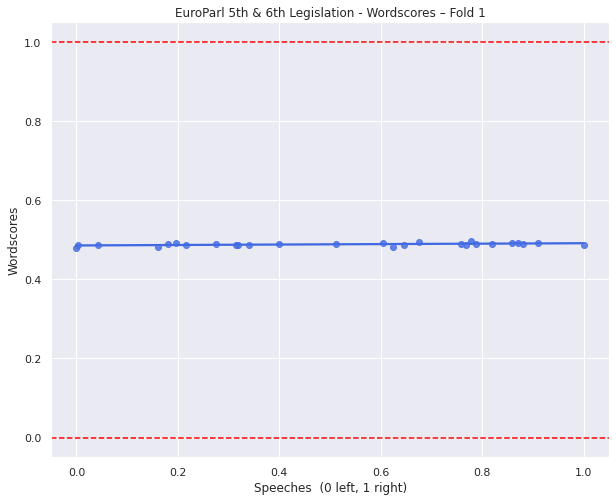

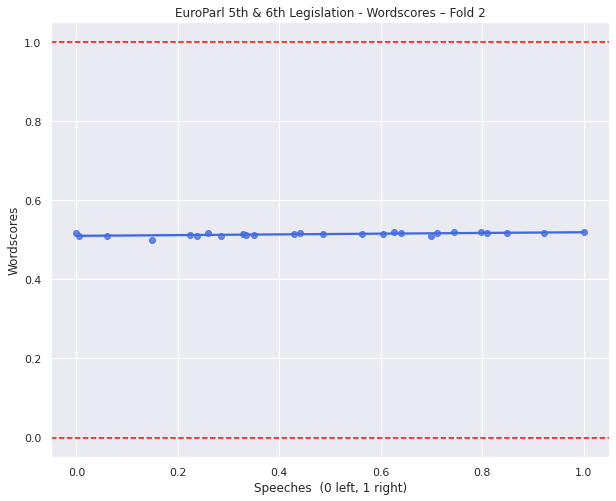

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import logging
import warnings
warnings.filterwarnings("ignore") 
import logging
logger = logging.getLogger().setLevel(logging.ERROR)
# Get number of folds
# For the int() to work, we first need to convert it to a numpy array
num_folds = int(robjects.r('num_folds')[0])

method_name = "Wordscores"
notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"


X = np.array(robjects.r['y_test'])
y = np.array(robjects.r['ws_results'])
for i in range(num_folds): 
    X[i] = np.array(X[i], dtype = np.float64)
    y[i] = np.array(y[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Speeches  (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [20]:
%%R
MSEs_ws <- mapply(mse, ws_results, y_test)

# Define normalization function
normalize <- function(x){(x-min(x))/(max(x)-min(x))}
ws_results_norm <- list()
for (i in 1:num_folds) {
    ws_results_norm[[i]] <- normalize(ws_results[[i]])
}

MSEs_ws_norm <- mapply(mse, ws_results_norm, y_test)

We also extract Pearson and Spearman correlation:

In [21]:
%%R
cor_p_ws <- mapply(cor, ws_results, y_test, method="pearson")
cor_s_ws <- mapply(cor, ws_results, y_test, method="spearman")

cor_p_ws_norm <- mapply(cor, ws_results_norm, y_test, method="pearson")
cor_s_ws_norm <- mapply(cor, ws_results_norm, y_test, method="spearman")

In [22]:
MSEs_ws = np.array(robjects.r['MSEs_ws'])
MSEs_df = MSEs_df.append(
            {"method": "Wordscores",
             "mean":np.mean(MSEs_ws),
             "std":np.std(MSEs_ws)},
            ignore_index=True)

cor_p_ws = np.array(robjects.r['cor_p_ws'])

cor_p_df = cor_p_df.append(
            {"method": "Wordscores",
             "mean":np.mean(cor_p_ws),
             "std":np.std(cor_p_ws)},
            ignore_index=True)

cor_s_ws = np.array(robjects.r['cor_s_ws'])

cor_s_df = cor_s_df.append(
            {"method": "Wordscores",
             "mean":np.mean(cor_s_ws),
             "std":np.std(cor_s_ws)},
            ignore_index=True)


MSEs_ws_norm = np.array(robjects.r['MSEs_ws_norm'])
MSEs_df = MSEs_df.append(
            {"method": "Wordscores (Norm.)",
             "mean":np.mean(MSEs_ws_norm),
             "std":np.std(MSEs_ws_norm)},
            ignore_index=True)

cor_p_ws_norm = np.array(robjects.r['cor_p_ws_norm'])

cor_p_df = cor_p_df.append(
            {"method": "Wordscores (Norm.)",
             "mean":np.mean(cor_p_ws_norm),
             "std":np.std(cor_p_ws_norm)},
            ignore_index=True)

cor_s_ws_norm = np.array(robjects.r['cor_s_ws_norm'])

cor_s_df = cor_s_df.append(
            {"method": "Wordscores (Norm.)",
             "mean":np.mean(cor_s_ws_norm),
             "std":np.std(cor_s_ws_norm)},
            ignore_index=True)

## Wordfish (frequency method)
Wordfish requires two labeled documents with opposite political positions as reference documents and from that Wordfish positions the other documents in relation to these two reference documents, as the reference documents get assigned both ends of the output scale. No further training is required. In order to simulate the typical train/test-data environment, we take two labeled documents from the training-data and append them to the test-data. On this, we will then run Wordfish.

First we need to find opposite documents:

In [23]:
%%R
for (i in 1:num_folds) {
  print(glue("Min of Fold {i}: {which.min(y_train[[i]])}"))
  print(glue("Max of Fold {i}: {which.max(y_train[[i]])}"))
  print(glue("---"))
}

Min of Fold 1: 14
Max of Fold 1: 6
---
Min of Fold 2: 4
Max of Fold 2: 15
---


We save the reference documents in the variable *wf_train_docs*:

In [24]:
%%R
wf_train_docs <- list()
# We select the documents from the training data by boolean values as indices
wf_train_docs[[1]] = dfm_subset(dfm_X_train[[1]], c(rep(FALSE, 5), TRUE, rep(FALSE,7), TRUE, rep(FALSE, length(X_train_processed[[1]])-14)))
wf_train_docs[[2]] = dfm_subset(dfm_X_train[[2]], c(rep(FALSE, 3), TRUE, rep(FALSE, 10) , TRUE, rep(FALSE, length(X_train_processed[[2]])-15)))

We check if the variable indeed contains the training texts:

In [25]:
%%R
for (i in 1:num_folds) {
    print(wf_train_docs[[i]][1:2,1])
}

Document-feature matrix of: 2 documents, 1 feature (0.0% sparse).
2 x 1 sparse Matrix of class "dfm"
        features
docs     mrs
  text6   36
  text14   3
Document-feature matrix of: 2 documents, 1 feature (0.0% sparse).
2 x 1 sparse Matrix of class "dfm"
        features
docs      mr
  text4  534
  text15  49


As we can see, the two texts form above are indeed inside the *wf_train_docs* document-feature matrix.

We append these two documents to the test-data, creating the variable *data_wf*. We then calculate the Wordfish results and save them in *wf_results*:

In [26]:
%%R
data_wf <- list()
wf_results <- list() 
for (i in 1:num_folds) {
    print(glue("Handling fold {i} out of {num_folds}"))
    data_wf[[i]] <- rbind(wf_train_docs[[i]], dfm_X_test[[i]]) # Add the two training docs at the top
    data_wf[[i]] <- dfm_trim(data_wf[[i]], min_docfreq = 1) # Only leave in documents that appear at least once
    }
# Because the first two documents are switched (max first instead of min, we need to switch
# the reference document vector -dir- from (1,2) to (2,1))
print(glue("Fold 1 out of {num_folds}"))
set.seed(42)
wf_results[[1]] <- textmodel_wordfish(data_wf[[1]], dir=c(2,1) , sparse = TRUE)$theta

print(glue("Fold 2 out of {num_folds}"))
set.seed(42)
wf_results[[2]] <- textmodel_wordfish(data_wf[[2]], dir=c(1,2) , sparse = TRUE)$theta

Handling fold 1 out of 2
Handling fold 2 out of 2
Fold 1 out of 2
Fold 2 out of 2


We drop the two reference documents which were put at the beginning of *wf_results* from every fold:

In [27]:
%%R
for (i in 1:num_folds) {
wf_results[[i]] <- wf_results[[i]][- c(1,2)]
}

We min-max normalize the Wordfish results to make them comparable to our other methods:

In [28]:
%%R
# Define normalization function
normalize <- function(x){(x-min(x))/(max(x)-min(x))}

wf_results_normalized <- list()
for (i in 1:num_folds) {
wf_results_normalized[[i]] <- normalize(wf_results[[i]])
}

We plot the normalized Wordfish results (just as we did with Wordscores):

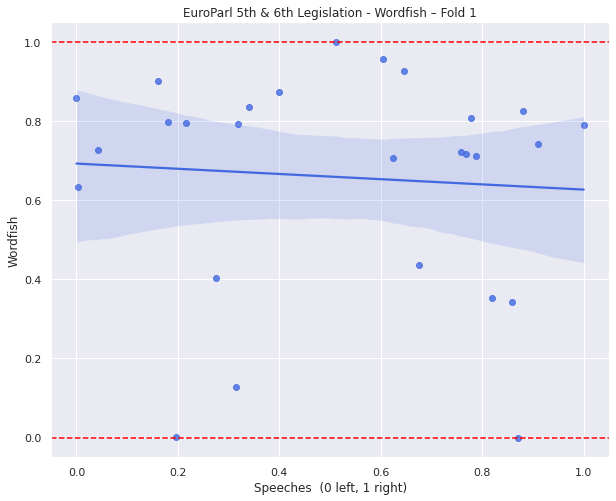

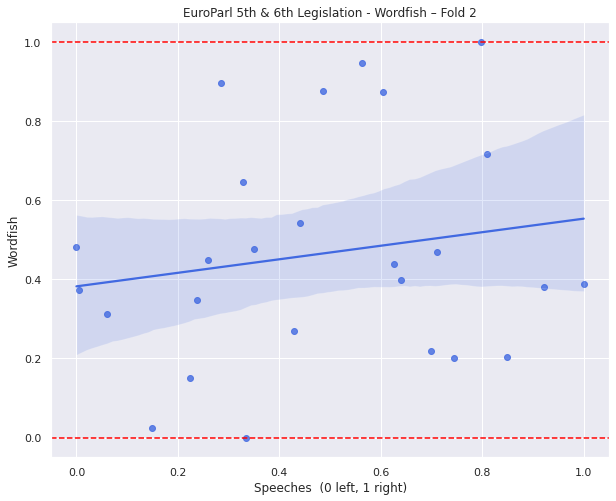

In [29]:
method_name = "Wordfish"
notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

X = np.array(robjects.r['y_test'])
y = np.array(robjects.r['wf_results_normalized'])
for i in range(num_folds): 
    X[i] = np.array(X[i], dtype = np.float64)
    y[i] = np.array(y[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Speeches  (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [30]:
%%R
MSEs_wf <- mapply(mse, wf_results_normalized, y_test)

We also extract Pearson and Spearman correlation:

In [31]:
%%R
cor_p_wf <- mapply(cor, wf_results_normalized, y_test, method="pearson")
cor_s_wf <- mapply(cor, wf_results_normalized, y_test, method="spearman")

In [32]:
MSEs_wf = np.array(robjects.r['MSEs_wf'])
MSEs_df = MSEs_df.append(
            {"method": "Wordfish (ONLY Norm.)",
             "mean":np.mean(MSEs_wf),
             "std":np.std(MSEs_wf)},
            ignore_index=True)

cor_p_wf = np.array(robjects.r['cor_p_wf'])

cor_p_df = cor_p_df.append(
            {"method": "Wordfish (ONLY Norm.)",
             "mean":np.mean(cor_p_wf),
             "std":np.std(cor_p_wf)},
            ignore_index=True)

cor_s_wf = np.array(robjects.r['cor_s_wf'])

cor_s_df = cor_s_df.append(
            {"method": "Wordfish (ONLY Norm.)",
             "mean":np.mean(cor_s_wf),
             "std":np.std(cor_s_wf)},
            ignore_index=True)

## SemScale (semantic method)

SemScale does not need training, thus we immediately input the test data. SemScale cannot be executed easily inside this notebook, as they are separate files published by the authors, supposed to be started via a bash command (which we will do here).

In order to run SemScale, we have to output our data into .txt files, and add a line with "en" to beginning of each text file. SemScale needs this to classify it as an English text.

We add the "en" at the beginning of each data point using the **unprocessed** variables:

In [33]:
%%R
X_test_sem <- list()

for (i in 1:num_folds) {
      X_test_sem[[i]] <- paste("en", X_test[[i]], sep="\n")
  }

We then create the aforementioned .txt files:

In [34]:
%%R
txt_folder = "txts/txts_europarl_combined"

In [35]:
%%R
for (i in 1:num_folds) {
  # Create folders for the text files
  folder_for_fold = glue(paste0(txt_folder, "_{i}"))
  dir.create(folder_for_fold)
  # Create text files
  for (j in 1:length(X_test[[i]])){
  filename = glue(paste0(folder_for_fold, "/{y_test[[i]][j]}_speech.txt"))
  write.table(X_test_sem[[i]][j], file=filename, row.names = FALSE, col.names=FALSE, quote=FALSE)
  }
}

We now call the SemScale script by using the bash console (if you started this notebook via bash, you can see the prints of SemScale in it):

In [36]:
%%R
for (i in 1:num_folds){
  folder_for_fold = glue(paste0(txt_folder, "_{i}"))
  # Execute in bash (Commented out so it doesn't run the process when running the notebook)
  print(glue("Processing fold {i} out of {num_folds}..."))
  # Because R does not support string concatiation via "+" we must take construct the string in parts...
  script_pt1 = glue(paste0("cd SemScale-master && python scaler.py ../", folder_for_fold))
  full_script = full_cmd = glue(paste(script_pt1, "../embeddings_semscale.vec ./../semscale_outputs/semscale_output_europarl_combined_{i}.txt"))
  
  if (!skipTraining) {
      system(full_script)
  }
}

Processing fold 1 out of 2...
Processing fold 2 out of 2...


The cell above outputs .csv files including the scores, which we now read back into our notebook:

In [37]:
%%R
sem_outputs <- list()
for (i in 1:num_folds){
  # Read each file
  sem_outputs[[i]] <- read.csv(glue("semscale_outputs/semscale_output_europarl_combined_{i}.txt"), sep="\t", header=FALSE)
}

We add back target labels (0/1 for left/right) to the output of SemScale, "sem_outputs":

In [38]:
%%R
for (i in 1:num_folds) {
  for (j in seq_along(sem_outputs[[i]][,1])) {
    sem_outputs[[i]][j,3] <- sub("\\_.*", "", sem_outputs[[i]][j,1])
  }
}


We plot the SemScale results (just as we did with Wordscores and Wordfish):

In [39]:
%%R
plot_sem_result <- list()
plot_target <- list()
for (i in 1:num_folds) {
    plot_sem_result[[i]] = sem_outputs[[i]][,2]
    plot_target[[i]] = sem_outputs[[i]][,3]
}

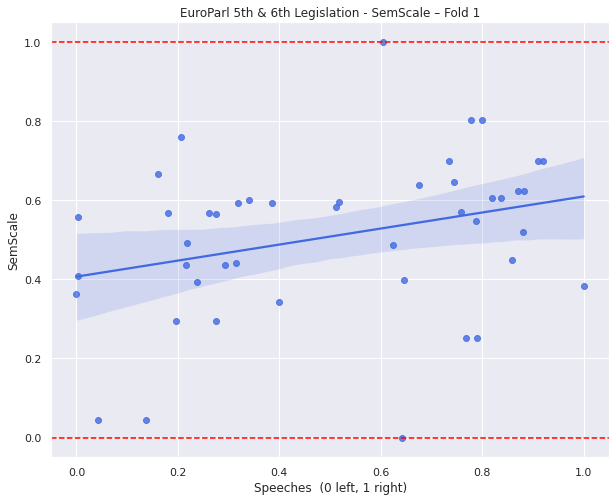

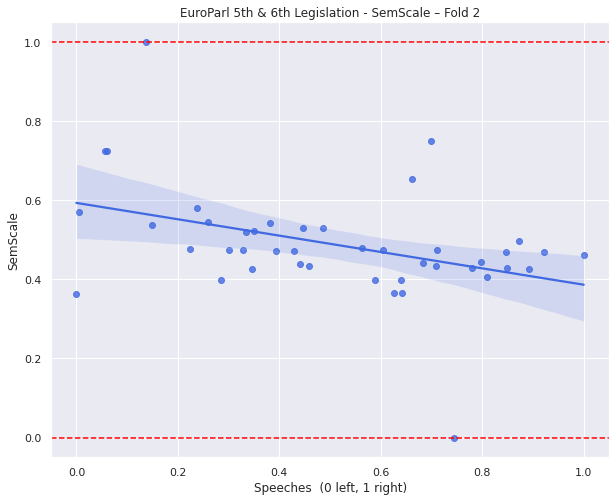

In [40]:
method_name = "SemScale"
notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

X = np.array(robjects.r['plot_target'])
y = np.array(robjects.r['plot_sem_result'])
for i in range(num_folds): 
    X[i] = np.array(X[i], dtype = np.float64)
    y[i] = np.array(y[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Speeches  (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [41]:
%%R
MSEs_sem <- c()
cor_p_sem <- c()
cor_s_sem <- c()
for (i in 1:num_folds) {
  MSEs_sem[i] <- (mse(sem_outputs[[i]][,2],as.numeric(sem_outputs[[i]][,3])))
  cor_p_sem[i] <- cor(sem_outputs[[i]][,2],as.numeric(sem_outputs[[i]][,3]), method="pearson")
  cor_s_sem[i] <- cor(sem_outputs[[i]][,2],as.numeric(sem_outputs[[i]][,3]), method="spearman")
}

In [42]:
MSEs_sem = np.array(robjects.r['MSEs_sem'])
MSEs_df = MSEs_df.append(
            {"method": "SemScale (ONLY Norm.)",
             "mean":np.mean(MSEs_sem),
             "std":np.std(MSEs_sem)},
            ignore_index=True)

cor_p_sem = np.array(robjects.r['cor_p_sem'])

cor_p_df = cor_p_df.append(
            {"method": "SemScale (ONLY Norm.)",
             "mean":np.mean(cor_p_sem),
             "std":np.std(cor_p_sem)},
            ignore_index=True)

cor_s_sem = np.array(robjects.r['cor_s_sem'])

cor_s_df = cor_s_df.append(
            {"method": "SemScale (ONLY Norm.)",
             "mean":np.mean(cor_s_sem),
             "std":np.std(cor_s_sem)},
            ignore_index=True)

# Python Setup
We start by importing the data from R into Python:

We copy over the variable names one by one, and make numpy arrays out of them with the datatype "object" in order to be memory-efficient.

In [43]:
import sqlite3
import pandas as pd
import sklearn
import multiprocessing
import torch
import gc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import tensorflow as tf
import random as rd
from keras.models import load_model
from simpletransformers.classification import ClassificationModel
from keras.utils import np_utils
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr


# We map the numpy array function over the extracted R variables
# in order to get the arrays inside as well as compatiblity with Python

# We specify object as the dtype in order to save memory

X_train = np.array([np.array(k, dtype=object) for k in robjects.r('X_train')])
y_train = np.array([np.array(k, dtype=object) for k in robjects.r('y_train')])

X_test = np.array([np.array(k, dtype=object) for k in robjects.r('X_test')])
y_test = np.array([np.array(k, dtype=object) for k in robjects.r('y_test')])

X_train_processed = np.array([np.array(k, dtype=object) for k in robjects.r('X_train_processed')])

X_test_processed = np.array([np.array(k, dtype=object) for k in robjects.r('X_test_processed')])



# We set some seeds for reproducable results of our methods using random methods


os.environ['PYTHONHASHSEED']=str(42)
rd.seed(42)
np.random.seed(42)
tf.random.set_seed(42)



wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.



## BERT (semantic method)


We now run BERT across all folds:

In [44]:
# Initialize predictions array
predictions = []

# Go over every fold
for i in range(num_folds):
    # We use the garbage collection and cache clearing
    # to not cause errors by the GPU memory being filled up
    print("Fold", i+1, "out of", num_folds)
    print("Freed memory:", gc.collect())
    torch.cuda.empty_cache()
    
    if skipTraining:
        
        model = ClassificationModel('bert', models_folder +'/bert_model_' + str(i) ,num_labels=1,
                                    use_cuda = useGPU,
                                    args={'overwrite_output_dir': True,
                                          "save_model_every_epoch": False,
                                          #'output_dir' : './models/bert_model_' + str(i),
                                          "regression": True,
                                          'num_train_epochs': 3,
                                          #"train_batch_size": 45,
                                          #"evaluate_during_training": True,
                                          #"evaluate_during_training_steps": 50,
                                          "fp16": False})
        
    else: # If no trained models exist, train them
        
        model = ClassificationModel('bert', 'bert-base-uncased',num_labels=1,
                            use_cuda = useGPU,
                            args={'overwrite_output_dir': True,
                                  "save_model_every_epoch": False,
                                  'output_dir' : models_folder + '/bert_model_' + str(i),
                                  "regression": True,
                                  'num_train_epochs': 3,
                                  "train_batch_size": 45,
                                  #"evaluate_during_training": True,
                                  #"evaluate_during_training_steps": 50,
                                  "fp16": False})

        # BERT requires us to concatinate training data and labels
        bert_train_df = pd.concat([pd.DataFrame(X_train[i]), pd.DataFrame(y_train[i])], axis=1)
        # We do the same for the evaluation data we check the validation loss with while training
        #bert_eval_df = pd.concat([pd.DataFrame(X_test[i]), pd.DataFrame(y_test[i])], axis=1)
        # We train the model
        #model.train_model(bert_train_df, eval_df=bert_eval_df)
        model.train_model(bert_train_df)
        
    predictions.append(model.predict(X_test[i])[0])
    
# Free up memory
#del model
print("Freed memory:", gc.collect())
torch.cuda.empty_cache()

Fold 1 out of 2
Freed memory: 22



Fold 2 out of 2
Freed memory: 20



Freed memory: 20


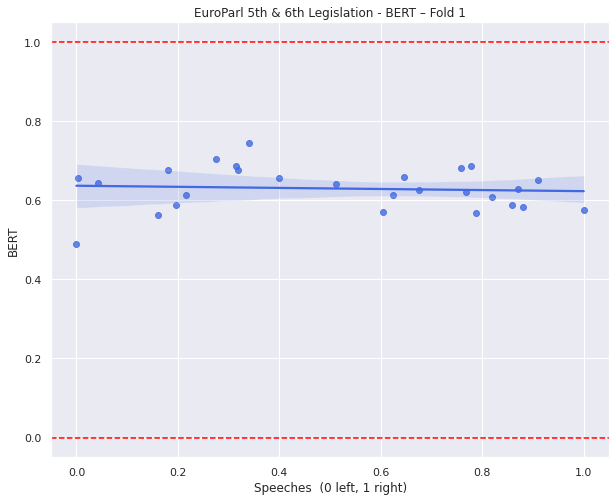

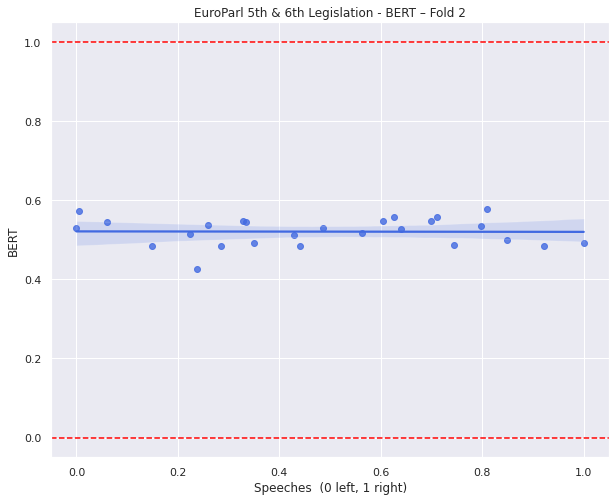

In [45]:
# Plot of the results
method_name = "BERT"
notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

for i in range(num_folds): 
    X[i] = np.array(y_test[i], dtype = np.float64)
    y[i] = np.array(predictions[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Speeches  (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:


In [46]:
MSEs_bert = list(map(mean_squared_error, predictions, y_test))

from sklearn.preprocessing import MinMaxScaler
predictions_norm = list()
for pred in predictions:
    
    scaler = MinMaxScaler()
    predictions_norm.append(scaler.fit_transform(pred.reshape(-1,1)))
    

# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions[x] = predictions[x].flatten()
    
# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions_norm[x] = predictions_norm[x].flatten()

    
MSEs_bert_norm = list(map(mean_squared_error, predictions_norm, y_test))

cor_p_bert = list(map(pearsonr, predictions, y_test))
cor_p_bert_norm = list(map(pearsonr, predictions_norm, y_test))

cor_s_bert = list(map(spearmanr, predictions, y_test)) 
cor_s_bert_norm = list(map(spearmanr, predictions_norm, y_test))    


MSEs_df = MSEs_df.append(
            {"method": "BERT",
             "mean":np.mean(MSEs_bert),
             "std":np.std(MSEs_bert)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "BERT",
             "mean":np.mean(cor_p_bert),
             "std":np.std(cor_p_bert)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "BERT",
             "mean":np.mean(cor_s_bert_norm),
             "std":np.std(cor_s_bert_norm)},
            ignore_index=True)

MSEs_df = MSEs_df.append(
            {"method": "BERT (Norm.)",
             "mean":np.mean(MSEs_bert_norm),
             "std":np.std(MSEs_bert_norm)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "BERT (Norm.)",
             "mean":np.mean(cor_p_bert_norm),
             "std":np.std(cor_p_bert_norm)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "BERT (Norm.)",
             "mean":np.mean(cor_s_bert_norm),
             "std":np.std(cor_s_bert_norm)},
            ignore_index=True)

We define a plotting function to plot the training progress of some methods:

In [47]:
def plot_history(history):
    mse = history.history['mse']
    val_mse = history.history['val_mse']
    x = range(1, len(mse) + 1)

    #plt.figure(figsize=(12, 5))
    plt.plot(x, mse, 'b', label='Training MSE')
    plt.plot(x, val_mse, 'r', label='Validation MSE')
    plt.title('Training and validation MSE')
    plt.legend()
    plt.show()


### Linear Regression with Token Counts (frequency method)

We use **count vectorization** by sklean to create matrices of vectors which contain token frequencies per document, basically like the document-feature matrices by Quanteda we used in R (bag-of-words model).

Since this is one of our word frequency methods, we use the **processed** data:

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
cv_X_train = []
cv_X_test = []

for i in range(num_folds):
    vectorizer = CountVectorizer()
    vectorizer.fit(X_train_processed[i])
    cv_X_train.append(vectorizer.transform(X_train_processed[i]))
    cv_X_test.append(vectorizer.transform(X_test_processed[i]))

We apply **linear regression** to the just created token count data and then min-max scale the outcome to the 0 to 1 range:

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
predictions = []

for i in range(num_folds):
    print("Fold", i+1, "out of", num_folds)
    # Calculate linear regression, this method is deterministic
    classifier = LinearRegression()
    classifier.fit(cv_X_train[i], y_train[i]) 
    prediction = classifier.predict(cv_X_test[i])
    # Append scaled prediction
    predictions.append(prediction)

#del classifier # Free up memory
print("Freed memory:", gc.collect())

Fold 1 out of 2
Fold 2 out of 2
Freed memory: 5237


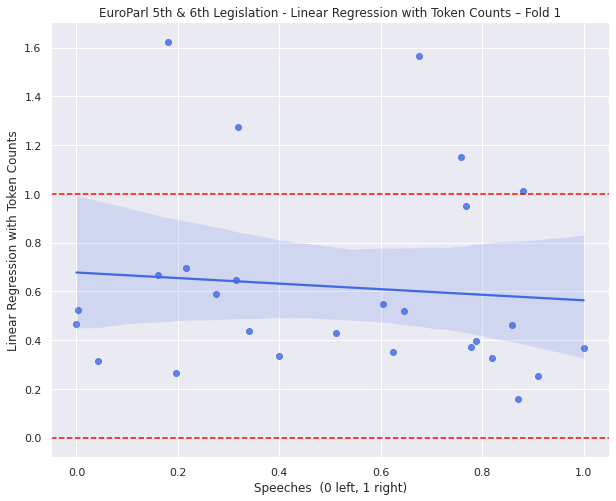

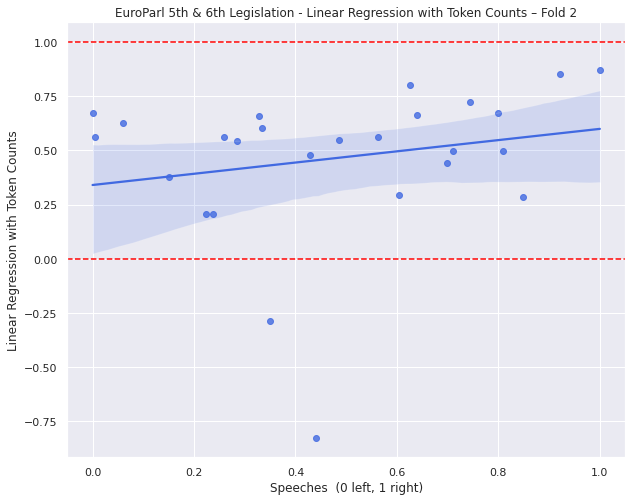

In [50]:
method_name = "Linear Regression with Token Counts"
notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

for i in range(num_folds): 
    X[i] = np.array(y_test[i], dtype = np.float64)
    y[i] = np.array(predictions[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Speeches  (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [51]:
MSEs_lin_reg_cv = list(map(mean_squared_error, predictions, y_test))
MSEs_lin_reg_cv_norm = list(map(mean_squared_error, predictions_norm, y_test))

predictions_norm = list()
for pred in predictions:
    
    scaler = MinMaxScaler()
    predictions_norm.append(scaler.fit_transform(pred.reshape(-1,1)))

# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions[x] = predictions[x].flatten()
    
# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions_norm[x] = predictions_norm[x].flatten()



cor_p_lin_reg_cv = list(map(pearsonr, predictions, y_test))
cor_p_lin_reg_cv_norm = list(map(pearsonr, predictions_norm, y_test))    

cor_s_lin_reg_cv = list(map(spearmanr, predictions, y_test))
cor_s_lin_reg_cv_norm = list(map(spearmanr, predictions_norm, y_test))

MSEs_df = MSEs_df.append(
            {"method": "Linear Regression Token Counts",
             "mean":np.mean(MSEs_lin_reg_cv),
             "std":np.std(MSEs_lin_reg_cv)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Linear Regression Token Counts",
             "mean":np.mean(cor_p_lin_reg_cv),
             "std":np.std(cor_p_lin_reg_cv)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Linear Regression Token Counts",
             "mean":np.mean(cor_s_lin_reg_cv),
             "std":np.std(cor_s_lin_reg_cv)},
            ignore_index=True)

MSEs_df = MSEs_df.append(
            {"method": "Linear Regression Token Counts (Norm.)",
             "mean":np.mean(MSEs_lin_reg_cv_norm),
             "std":np.std(MSEs_lin_reg_cv_norm)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Linear Regression Token Counts (Norm.)",
             "mean":np.mean(cor_p_lin_reg_cv_norm),
             "std":np.std(cor_p_lin_reg_cv_norm)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Linear Regression Token Counts (Norm.)",
             "mean":np.mean(cor_s_lin_reg_cv_norm),
             "std":np.std(cor_s_lin_reg_cv_norm)},
            ignore_index=True)

### Feed-Forward Neural Network with Token Counts (frequency method)

We now prepare the dataset for the feed-forward neural network.

As we can see, the data we used before is stored as a sparse matrix:

In [52]:
cv_X_train[0]

<26x18103 sparse matrix of type '<class 'numpy.int64'>'
	with 108447 stored elements in Compressed Sparse Row format>

We thus first transform it to arrays, which Keras can work with:

In [53]:

import scipy
# Initialize arrays for neural network data
nn_cv_X_train= []
nn_cv_X_test = []

for i in range(num_folds):
    # Transform to arrays compatible with neural networks
    nn_cv_X_train.append(scipy.sparse.csr_matrix.toarray(cv_X_train[i]))
    nn_cv_X_test.append(scipy.sparse.csr_matrix.toarray(cv_X_test[i]))


We feed to data we just transformed into the array format into a feed-forward neural network:

In [54]:
from keras.models import Sequential
from keras import layers

predictions = []

for i in range(num_folds):

    print("Fold", i+1, "out of", num_folds)
    if skipTraining:
        model = load_model(models_folder +'/ff_tc_' + str(i))
    else: 
        # We create a sequential model
        model = Sequential()
        # We add a first layer, a hidden layer, and an output layer
        model.add(layers.Dense(20 ,activation='relu'))
        model.add(layers.Dense(50,activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))

        # We compile the model
        model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mse'])
        # We save the model's history for plotting
        history = model.fit(np.array(nn_cv_X_train[i], dtype=np.float), np.array(y_train[i], dtype=np.float),
                          epochs=5,
                          verbose=False,
                          validation_data=(np.array(nn_cv_X_test[i], dtype=np.float), np.array(y_test[i], dtype=np.float)),
                          batch_size=30)

        # We plot the history data created above
        plot_history(history)

    # We create predictions on the test data
    predictions.append(model.predict(nn_cv_X_test[i]))

    # Save model files if training is note skipped
    if not skipTraining:
        model.save(models_folder + '/ff_tc_' + str(i))

#del nn_cv_X_train
#del nn_cv_X_test
#del model # Free up memory
print("Freed memory:", gc.collect())

Fold 1 out of 2
Fold 2 out of 2
Freed memory: 8812


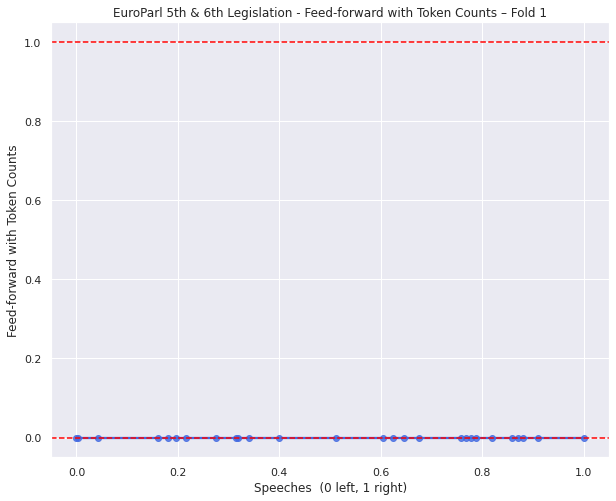

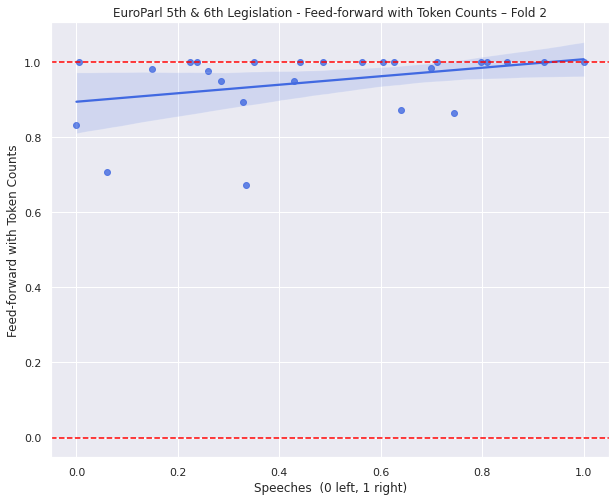

In [55]:
method_name = "Feed-forward with Token Counts"
notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

for i in range(num_folds): 
    X[i] = np.array(y_test[i], dtype = np.float64)
    y[i] = np.array(predictions[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Speeches  (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [56]:
MSEs_ff_cv = list(map(mean_squared_error, predictions, y_test))

from sklearn.preprocessing import MinMaxScaler
predictions_norm = list()
for pred in predictions:
    
    scaler = MinMaxScaler()
    predictions_norm.append(scaler.fit_transform(pred.reshape(-1,1)))
    

# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions[x] = predictions[x].flatten()
    
# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions_norm[x] = predictions_norm[x].flatten()

    
MSEs_ff_cv_norm = list(map(mean_squared_error, predictions_norm, y_test))

cor_p_ff_cv = list(map(pearsonr, predictions, y_test))
cor_p_ff_cv_norm = list(map(pearsonr, predictions_norm, y_test))

cor_s_ff_cv = list(map(spearmanr, predictions, y_test)) 
cor_s_ff_cv_norm = list(map(spearmanr, predictions_norm, y_test))    


MSEs_df = MSEs_df.append(
            {"method": "Feed Forward Token Counts",
             "mean":np.mean(MSEs_ff_cv),
             "std":np.std(MSEs_ff_cv)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Feed Forward Token Counts",
             "mean":np.mean(cor_p_ff_cv),
             "std":np.std(cor_p_ff_cv)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Feed Forward Token Counts",
             "mean":np.mean(cor_s_ff_cv_norm),
             "std":np.std(cor_s_ff_cv_norm)},
            ignore_index=True)

MSEs_df = MSEs_df.append(
            {"method": "Feed Forward Token Counts (Norm.)",
             "mean":np.mean(MSEs_ff_cv_norm),
             "std":np.std(MSEs_ff_cv_norm)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Feed Forward Token Counts (Norm.)",
             "mean":np.mean(cor_p_ff_cv_norm),
             "std":np.std(cor_p_ff_cv_norm)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Feed Forward Token Counts (Norm.)",
             "mean":np.mean(cor_s_ff_cv_norm),
             "std":np.std(cor_s_ff_cv_norm)},
            ignore_index=True)

Now we create another tokenized version of our data, but this time inside the Keras environment. Later we will create the word embedding matrix from this. Since this will be used for the semantic methods, we use the **unprocessed** data.

We save the fitted tokenizers for each fold into a list named *tokenizers*, also the vocabulary sizes into *vocab_sizes* as we will need these later when we construct our embedding matrix:

In [57]:
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Initialize list of tokenizers
tokenizers = []
# Initiliaze arrays of training data
tok_X_train = []
tok_y_train = []
tok_X_test = []
tok_y_test = []
# Vocabulary sizes
vocab_sizes = []

# As we have 1000 words, we chose to give the tokenized data a maximum length of 1050,
# just to be sure.
maxlen = 1050

for i in range(num_folds):
    # We initialize and fit the tokenizers
    tokenizers.append(Tokenizer())
    tokenizers[i].fit_on_texts(X_train[i])
    tok_X_train.append(tokenizers[i].texts_to_sequences(X_train[i]))
    tok_X_test.append(tokenizers[i].texts_to_sequences(X_test[i]))
    vocab_sizes.append(len(tokenizers[i].word_index) + 1)

    tok_X_train[i] = (pad_sequences(tok_X_train[i], padding='post', maxlen=maxlen))
    tok_X_test[i] = (pad_sequences(tok_X_test[i], padding='post', maxlen=maxlen))
    tok_y_train.append(np_utils.to_categorical(y_train[i]))
    tok_y_test.append(np_utils.to_categorical(y_test[i]))


We make the embedding process more efficient by creating an optimized embedding matrix which only contains the embeddings for the words actually appearing in the text corpus. We define the function which we will call later:

In [58]:
# This function is based on a function from https://realpython.com/python-keras-text-classification/

def create_optimized_embedding_matrix(matrix_file, word_index, embedding_dim, vocab_size):
    vocab_size = len(word_index) + 1
    # Initialize the embedding matrix
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    # We have to add an "en__" prefix to every key, because we analyze English documents
    word_index = {'en__' + key : value for key, value in word_index.items()}
    with open(matrix_file) as f:
        for line in f:
            # Extract the embeddings for every word in the embeddings file
            word, *emb_vector = line.split()
            # Check the word appears in our text corpus
            if word in word_index:
                # We add the corresponding vector of that word to our embedding matrix
                embedding_matrix[word_index[word]] = np.array(emb_vector, dtype=object)[:embedding_dim]
    return embedding_matrix

### Linear Regression with Embeddings (semantic method)

We now apply the function defined above to create an embedding matrix on which we will train linear regression:

In [59]:
embedding_dim = 300 # The embedding matrix contains 300 semantic values for each word

emb_X_train = []
emb_X_test = []

for i in range(num_folds):
    if skipTraining:
        model = load_model(models_folder + '/nn_emb_' + str(i))
    else: 
        # We create the embedding matrix
        print("Creating fold", i+1, "out of", num_folds)
        embedding_matrix = create_optimized_embedding_matrix(
            'embeddings_semscale.vec',
            tokenizers[i].word_index,
            embedding_dim,
            vocab_sizes[i])

        # We use the embedding layer and flatten the results to work with it later
        model = Sequential()
        model.add(layers.Embedding(input_dim=vocab_sizes[i], 
                               output_dim=embedding_dim, 
                               input_length=maxlen,
                               weights=[embedding_matrix],
                               trainable=False))
        model.add(layers.Flatten(trainable=False))
        model.trainable = False
        model.compile('adam', 'mse')
        
        # Save model files
        model.save(models_folder + '/nn_emb_' + str(i))
    # We create the actual embedded training and testing data
    # The term "predict" is misleading here, we merely feed the
    # data through the construct we created in the last lines.
    emb_X_train.append(model.predict(tok_X_train[i]))
    emb_X_test.append(model.predict(tok_X_test[i]))

print("Freed memory:", gc.collect())

Freed memory: 9136


As we can see above, we use Keras in a similar fashion as when we trained the feed-forward neural network, however, this construct here does not contain any trainable parameters. We merely have an embedding layer, which creates our final training and testing data (as we feed it the embedding matrix and our tokenized data). At the end, we have added a flatten layer, in order to flatten the array structure for later work with it.

We apply **linear regression** to the **embedded data** we just created:

In [60]:
from sklearn.linear_model import LinearRegression

predictions = []

for i in range(num_folds):
    print("Fold", i+1, "out of", num_folds)
    # Calculate linear regression, this method is deterministic
    classifier = LinearRegression()
    classifier.fit(emb_X_train[i], y_train[i])  
    predictions.append(classifier.predict(emb_X_test[i]))
#del classifier
print("Freed memory:", gc.collect())
print("DONE!")

Fold 1 out of 2
Fold 2 out of 2
Freed memory: 20
DONE!


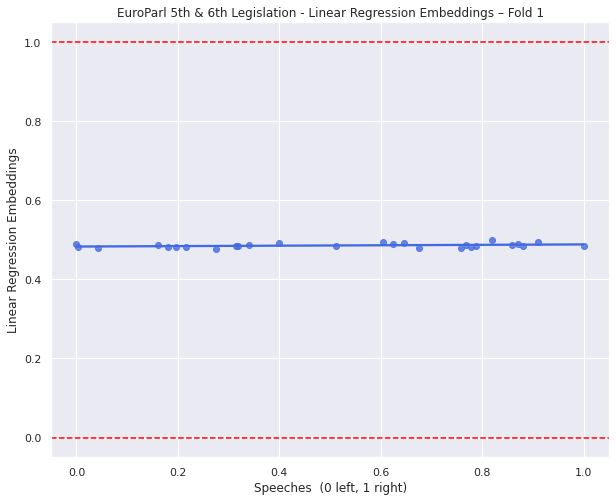

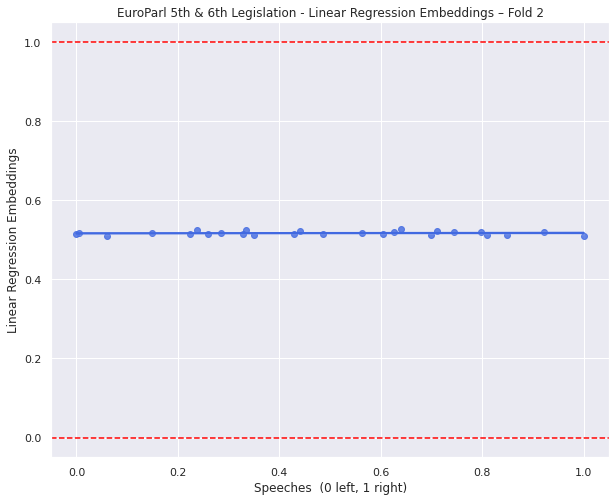

In [61]:
method_name = "Linear Regression Embeddings"
notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

for i in range(num_folds): 
    X[i] = np.array(y_test[i], dtype = np.float64)
    y[i] = np.array(predictions[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Speeches  (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [62]:
MSEs_lin_reg_embedding = list(map(mean_squared_error, predictions, y_test))

from sklearn.preprocessing import MinMaxScaler
predictions_norm = list()
for pred in predictions:
    
    scaler = MinMaxScaler()
    predictions_norm.append(scaler.fit_transform(pred.reshape(-1,1)))
    

# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions[x] = predictions[x].flatten()
    
# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions_norm[x] = predictions_norm[x].flatten()

    
MSEs_lin_reg_embedding_norm = list(map(mean_squared_error, predictions_norm, y_test))

cor_p_lin_reg_embedding = list(map(pearsonr, predictions, y_test))
cor_p_lin_reg_embedding_norm = list(map(pearsonr, predictions_norm, y_test))

cor_s_lin_reg_embedding = list(map(spearmanr, predictions, y_test)) 
cor_s_lin_reg_embedding_norm = list(map(spearmanr, predictions_norm, y_test))    


MSEs_df = MSEs_df.append(
            {"method": "Linear Regression Embeddings",
             "mean":np.mean(MSEs_lin_reg_embedding),
             "std":np.std(MSEs_lin_reg_embedding)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Linear Regression Embeddings",
             "mean":np.mean(cor_p_lin_reg_embedding),
             "std":np.std(cor_p_lin_reg_embedding)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Linear Regression Embeddings",
             "mean":np.mean(cor_s_lin_reg_embedding_norm),
             "std":np.std(cor_s_lin_reg_embedding_norm)},
            ignore_index=True)

MSEs_df = MSEs_df.append(
            {"method": "Linear Regression Embeddings (Norm.)",
             "mean":np.mean(MSEs_lin_reg_embedding_norm),
             "std":np.std(MSEs_lin_reg_embedding_norm)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Linear Regression Embeddings (Norm.)",
             "mean":np.mean(cor_p_lin_reg_embedding_norm),
             "std":np.std(cor_p_lin_reg_embedding_norm)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Linear Regression Embeddings (Norm.)",
             "mean":np.mean(cor_s_lin_reg_embedding_norm),
             "std":np.std(cor_s_lin_reg_embedding_norm)},
            ignore_index=True)

### Feed-Forward Neural Network with Embeddings (semantic method)

The same embedded data will be fed to a feed-forward neural network:

In [63]:
predictions = []
histories = []

for i in range(num_folds):
    print("Fold", i+1, "out of", num_folds)
    if skipTraining:
        model = load_model(models_folder + '/ff_emb_' + str(i))
    else: 
        model = Sequential()
        model.add(layers.Dense(20 ,activation='relu'))
        model.add(layers.Dense(50,activation='relu'))    
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['mse'])


        history = model.fit(np.array(emb_X_train[i], dtype=np.float), np.array(y_train[i], dtype=np.float),
                          epochs=15,
                          verbose=True,
                          validation_data=(np.array(emb_X_test[i], dtype=np.float), np.array(y_test[i], dtype=np.float)),
                          batch_size=500)



        plot_history(history)
    
    predictions.append(model.predict(np.array(emb_X_test[i], dtype=np.float)))
    
    
    if not os.path.isfile(models_folder + '/ff_emb_' + str(i)):
        model.save(models_folder + '/ff_emb_' + str(i))


print("Freed memory:", gc.collect())

Fold 1 out of 2
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/models_europarl_combined/ff_emb_0/assets
Fold 2 out of 2
INFO:tensorflow:Assets written to: models/models_europarl_combined/ff_emb_1/assets
Freed memory: 11866


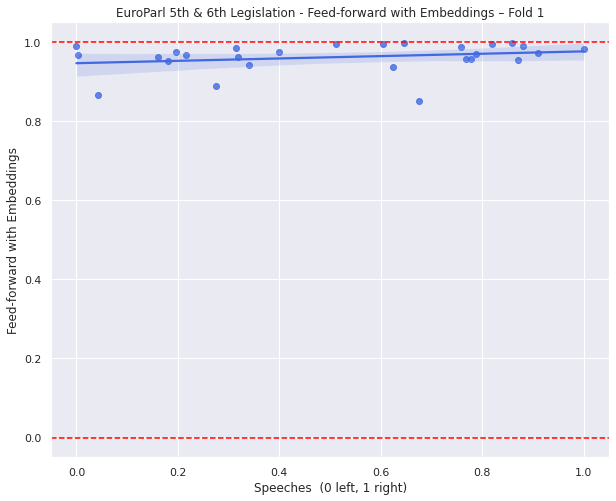

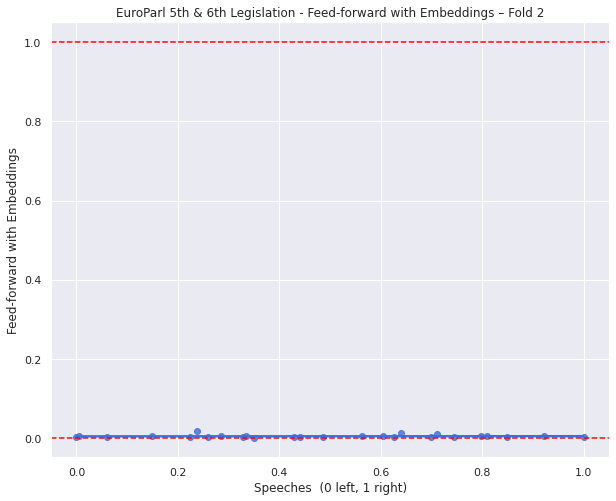

In [64]:
method_name = "Feed-forward with Embeddings"
notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name  + "/" + method_name + "/"

for i in range(num_folds): 
    X[i] = np.array(y_test[i], dtype = np.float64)
    y[i] = np.array(predictions[i], dtype = np.float64)

if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)
for i in range(num_folds):
    sns.set(rc={'figure.figsize':(10,8)})
    fig = sns.regplot(x=X[i], y=y[i], color="royalblue")
    fig.set_xlim(-0.05,1.05) # So points aren't cut off on the sides
    plt.axhline(1, ls='--', color="red")
    plt.axhline(0, ls='--', color="red")
    fig.set_xlabel("Speeches  (0 left, 1 right)")
    fig.set_ylabel(method_name)
    fig.set_title(notebook_name + " - " + method_name + " – Fold " + str(i + 1))
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".svg")
    fig.get_figure().savefig(fig_dir + method_name + notebook_name + str(i + 1) + ".pdf")
    plt.show()

We extract the metrics for later analysis:

In [65]:
MSEs_ff_embedding = list(map(mean_squared_error, predictions, y_test))

from sklearn.preprocessing import MinMaxScaler
predictions_norm = list()
for pred in predictions:
    
    scaler = MinMaxScaler()
    predictions_norm.append(scaler.fit_transform(pred.reshape(-1,1)))
    

# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions[x] = predictions[x].flatten()
    
# The implementations of the correlations require some array reshpaing
for x in range(num_folds):
    predictions_norm[x] = predictions_norm[x].flatten()

    
MSEs_ff_embedding_norm = list(map(mean_squared_error, predictions_norm, y_test))

cor_p_ff_embedding = list(map(pearsonr, predictions, y_test))
cor_p_ff_embedding_norm = list(map(pearsonr, predictions_norm, y_test))

cor_s_ff_embedding = list(map(spearmanr, predictions, y_test)) 
cor_s_ff_embedding_norm = list(map(spearmanr, predictions_norm, y_test))    


MSEs_df = MSEs_df.append(
            {"method": "Feed Forward Embeddings",
             "mean":np.mean(MSEs_ff_embedding),
             "std":np.std(MSEs_ff_embedding)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Feed Forward Embeddings",
             "mean":np.mean(cor_p_ff_embedding),
             "std":np.std(cor_p_ff_embedding)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Feed Forward Embeddings",
             "mean":np.mean(cor_s_ff_embedding_norm),
             "std":np.std(cor_s_ff_embedding_norm)},
            ignore_index=True)

MSEs_df = MSEs_df.append(
            {"method": "Feed Forward Embeddings (Norm.)",
             "mean":np.mean(MSEs_ff_embedding_norm),
             "std":np.std(MSEs_ff_embedding_norm)},
            ignore_index=True)

cor_p_df = cor_p_df.append(
            {"method": "Feed Forward Embeddings (Norm.)",
             "mean":np.mean(cor_p_ff_embedding_norm),
             "std":np.std(cor_p_ff_embedding_norm)},
            ignore_index=True)

cor_s_df = cor_s_df.append(
            {"method": "Feed Forward Embeddings (Norm.)",
             "mean":np.mean(cor_s_ff_embedding_norm),
             "std":np.std(cor_s_ff_embedding_norm)},
            ignore_index=True)

## Final Results

We now plot the **MSEs**:

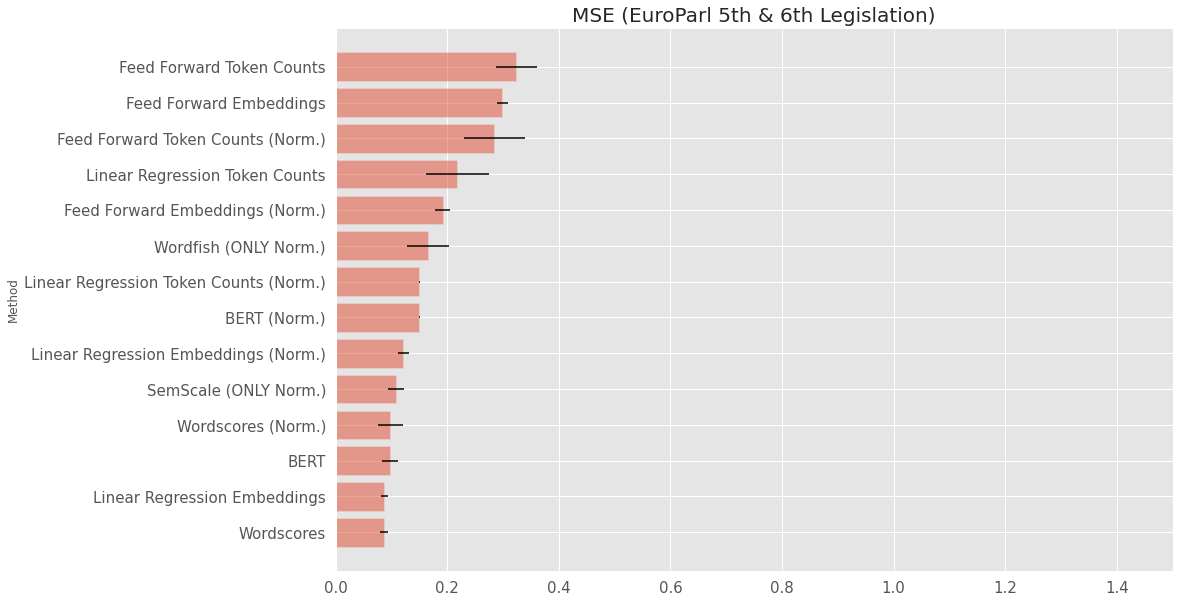

In [66]:
from matplotlib import pyplot as plt

MSEs_df = MSEs_df.sort_values(by="mean", ascending=True)
MSEs_df.reset_index(drop=True, inplace=True)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(MSEs_df["method"], MSEs_df["mean"], xerr=MSEs_df["std"], align='center', alpha=0.5, ecolor='black')
ax.set_ylabel('Method')
ax.set_title('MSE (EuroParl 5th & 6th Legislation)', fontsize=20)
ax.tick_params(labelsize=15, labelrotation=0)
ax.yaxis.grid(True)
ax.set_xlim(0, 1.5)

notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name + "/"
fig.savefig(fig_dir + notebook_name + "MSEs.svg", bbox_inches='tight')
fig.savefig(fig_dir + notebook_name + "MSEs.pdf", bbox_inches='tight')

Now the **pearson correlations**:

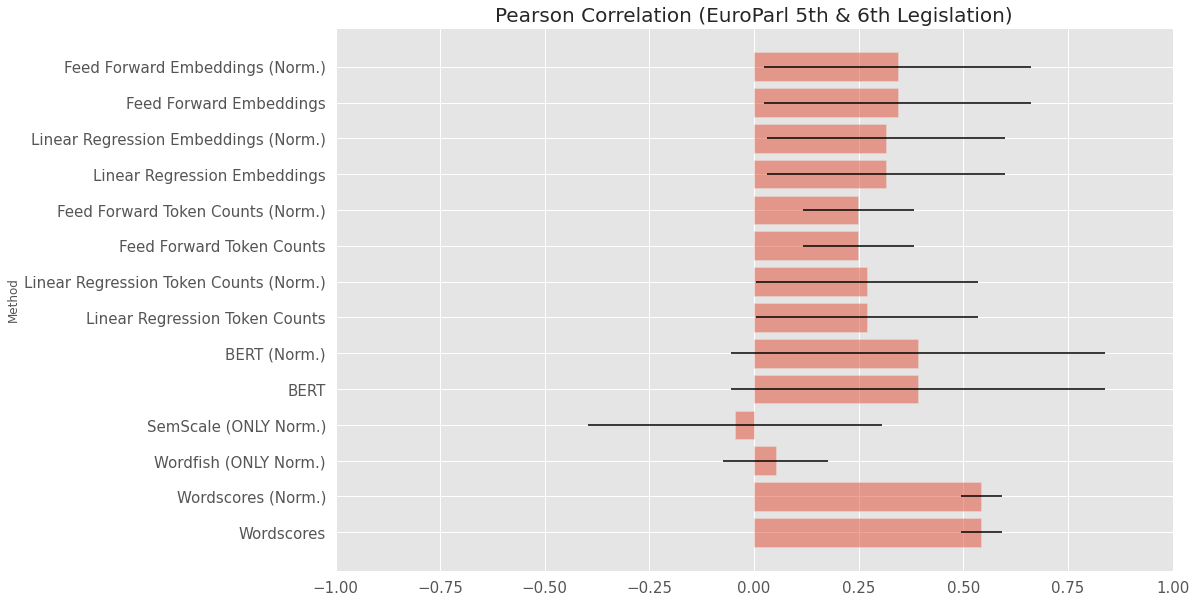

In [67]:
from matplotlib import pyplot as plt

MSEs_df = MSEs_df.sort_values(by="mean", ascending=True)
MSEs_df.reset_index(drop=True, inplace=True)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(cor_p_df["method"], cor_p_df["mean"], xerr=cor_p_df["std"], align='center', alpha=0.5, ecolor='black')
ax.set_ylabel('Method')
ax.set_title('Pearson Correlation (EuroParl 5th & 6th Legislation)', fontsize=20)
ax.tick_params(labelsize=15, labelrotation=0)
ax.yaxis.grid(True)
ax.set_xlim(-1,1)

notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name + "/"
fig.savefig(fig_dir + notebook_name + "cor_p.svg", bbox_inches='tight')
fig.savefig(fig_dir + notebook_name + "cor_p.pdf", bbox_inches='tight')

Now the **spearman correlations**:

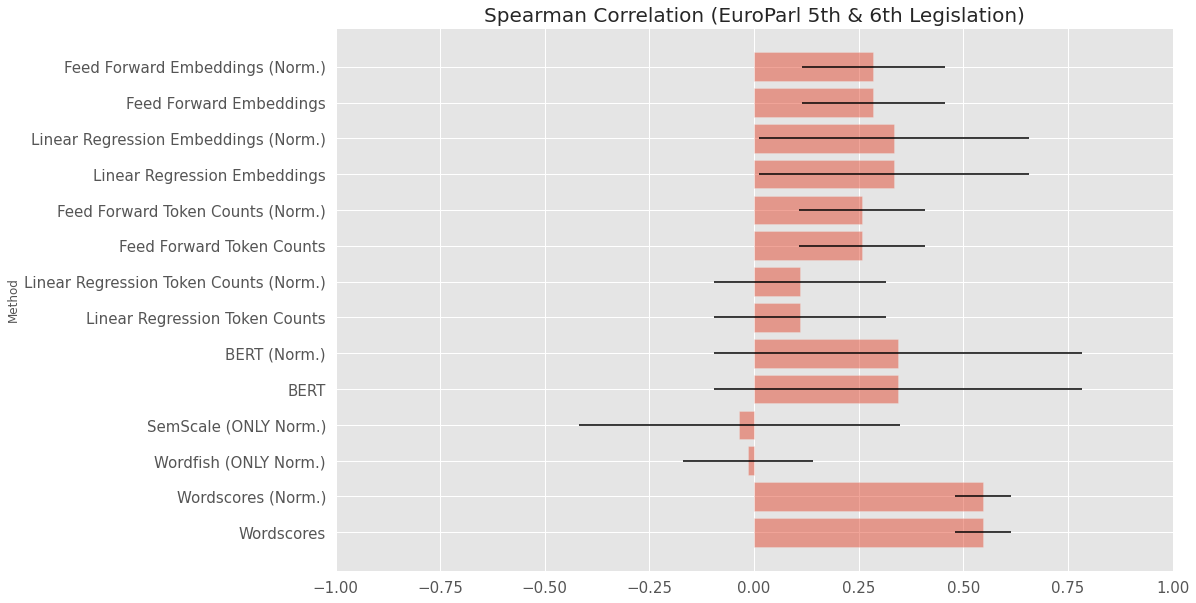

In [68]:
from matplotlib import pyplot as plt

MSEs_df = MSEs_df.sort_values(by="mean", ascending=True)
MSEs_df.reset_index(drop=True, inplace=True)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(cor_s_df["method"], cor_s_df["mean"], xerr=cor_s_df["std"], align='center', alpha=0.5, ecolor='black')
ax.set_ylabel('Method')
ax.set_title('Spearman Correlation (EuroParl 5th & 6th Legislation)', fontsize=20)
ax.tick_params(labelsize=15, labelrotation=0)
ax.yaxis.grid(True)
ax.set_xlim(-1,1)

notebook_name = "EuroParl 5th & 6th Legislation"
fig_dir = "figs/" + notebook_name + "/"
fig.savefig(fig_dir + notebook_name + "cor_s.svg", bbox_inches='tight')
fig.savefig(fig_dir + notebook_name + "cor_s.pdf", bbox_inches='tight')

We show the final **MSEs** in a table:

In [69]:
# Save results
if not os.path.exists("./results/europarl_combined"):
    os.makedirs("./results/europarl_combined")
MSEs_df.to_csv("./results/europarl_combined/MSEs.csv", index=False)
MSEs_df

,method,mean,std
0,Wordscores,0.086626,0.007452
1,Linear Regression Embeddings,0.087471,0.006829
2,BERT,0.097562,0.015162
3,Wordscores (Norm.),0.098308,0.021664
4,SemScale (ONLY Norm.),0.107976,0.014554
5,Linear Regression Embeddings (Norm.),0.121729,0.009879
6,BERT (Norm.),0.150077,0.000868
7,Linear Regression Token Counts (Norm.),0.150077,0.000868
8,Wordfish (ONLY Norm.),0.165600,0.037844
9,Feed Forward Embeddings (Norm.),0.192084,0.013132


We show the final **pearson correlations** in a table:

In [70]:
cor_p_df.to_csv("results/europarl_combined/cor_p.csv", index=False)
cor_p_df

,method,mean,std
0,Wordscores,0.543320,0.049064
1,Wordscores (Norm.),0.543320,0.049064
2,Wordfish (ONLY Norm.),0.051520,0.124763
3,SemScale (ONLY Norm.),-0.045562,0.352043
4,BERT,0.391464,0.446789
5,BERT (Norm.),0.391464,0.446789
6,Linear Regression Token Counts,0.268925,0.265124
7,Linear Regression Token Counts (Norm.),0.268925,0.265124
8,Feed Forward Token Counts,0.249207,0.133194
9,Feed Forward Token Counts (Norm.),0.249207,0.133194


We show the final **spearman correlations** in a table:

In [71]:
cor_s_df.to_csv("results/europarl_combined/cor_s.csv", index=False)
cor_s_df

,method,mean,std
0,Wordscores,0.547375,0.066300
1,Wordscores (Norm.),0.547375,0.066300
2,Wordfish (ONLY Norm.),-0.013956,0.155153
3,SemScale (ONLY Norm.),-0.035302,0.383469
4,BERT,0.344115,0.439015
5,BERT (Norm.),0.344115,0.439015
6,Linear Regression Token Counts,0.110436,0.205507
7,Linear Regression Token Counts (Norm.),0.110436,0.205507
8,Feed Forward Token Counts,0.258268,0.149818
9,Feed Forward Token Counts (Norm.),0.258268,0.149818


We now check how long the notebook took to run:

In [72]:
# We now combine the metrics and 
# append them to the file 'results/all_metrics.csv'
# which we use to store the metrics of all the notebooks

# First, we transform the metrics dataframes in order to
# keep the information which numbers represent which metrics
# and from which notebook they are coming from.
# That way we can later access
# that information in the 'results/all_metrics.csv' file

new_MSEs_df = MSEs_df.set_index("method").transpose().rename(index={"mean": "MSE (Avg) " + \
                notebook_name, \
                "std":  "MSE (Std) " + notebook_name})

                

new_cor_p_df = cor_p_df.set_index("method").transpose().rename(index={"mean": "Pearson Corr. (Avg) " + \
                notebook_name, \
                "std":  "Pearson Corr. (Std) " + notebook_name})



new_cor_s_df = cor_s_df.set_index("method").transpose().rename(index={"mean": "Spearman Corr. (Avg) " + \
                notebook_name, \
                "std":  "Spearman Corr. (Std) " + notebook_name})


# We combine all the metrics
combined_metrics = new_MSEs_df.append([new_cor_p_df,new_cor_s_df])
combined_metrics = combined_metrics.sort_index(axis=1)

# We either create a new all_metrics.csv file
# (if this is the first notebook to run after manually deleting the results folder)
# or append it to the already existing one all_metrics.csv file
if (os.path.isfile('results/all_metrics.csv')):
    previous_combined_metrics = pd.read_csv('results/all_metrics.csv', index_col=0)
    combined_metrics = previous_combined_metrics.append(combined_metrics)
    # In case this notebook is run again, we only keep the new results
    combined_metrics = combined_metrics[~combined_metrics.index.duplicated(keep='last')]
    combined_metrics.to_csv('results/all_metrics.csv', header=True)
else:
    combined_metrics.to_csv('results/all_metrics.csv', header=True)

In [73]:
end_time = datetime.datetime.now()
print("The notebook took to run:", end_time-start_time)

The notebook took to run: 0:02:12.148385
